In [1]:
%pip install haversine

Note: you may need to restart the kernel to use updated packages.


## RoadMap:

1. Determine how to calculate distances between two coordinates given their longitude and latitude.

    The answer to this is the Haversine formula, which has luckily been turned into a Python library.
2. Expand this to work on a full array of coordinates.

    This requires "pairwise" iteration. Pairwise iteration example on a string "ABCDEF" -> AB, BC, CD, DE, DF. Thus, we use pairwise iteration and apply Haversine to form an array that contains the distances between coordinates.

3. Simplify the problem and work with smaller examples that don't have us ending up between points. 

    We must be able to identify the coordinates in this simple case before worrying about what happens when we end up between points. Goal: Construct a coordinate-by-time C in this simple case.

4. Add support to work with "fractional points".

    This refers to finding the difference between points and multiplying by some ratio. This ratio will be the distance traveled between points to the total distance between points. This also includes knowing how to keep a working index in the distances array given that it's entirely possible that there are never nice integer indexes.

5. Add support to first find checkpoints and then identify at what times we will reach them.

6. Determine a correct way to insert 45-minute intervals of 0's in the speed array and theoretical distance array as the algorithm is running! This way, you don't have to keep redoing computations that you already did for the parts of the array that work.

In [2]:
import numpy as np
import itertools as it 
from math import hypot, radians
from haversine import haversine
from matplotlib import pyplot as plt
from sklearn.neighbors import BallTree

# Step 1
Determine how to calculate distances between two coordinates given their longitude and latitude.

We're working with Euclidean `(straight-line)` distances for now and using paths defined with Cartesian `(x,y)` coordinates.

We can easily replace this with Haversine `(great-circle)` distances in the future. Euclidean distances just make it easier to reason about. 

In [3]:
def calculate_distance(p1,p2, print=True):
    """Calculate Euclidean distance between two points."""
    x1,y1 = p1
    x2,y2 = p2
    if print:
      print(f"{p1},{p2}") 
    return round(hypot(x2 - x1, y2 - y1), 2)

# Plot Graph helper method 
def simple_plot_graph(data, title, visible=True):
    """

    Args:
        visible: A control flag specifying if the plot should be shown
        data: A NumPy[n] array of data to plot
        title: The graph title

    Result: Displays a graph of the data using Matplotlib

    """
    fig, ax = plt.subplots()
    x = np.arange(0, len(data))
    ax.plot(x, data)
    plt.title(title)
    if visible:
        plt.show()

In [4]:
# Step 1 Test:
pt0 = [0, 0]
pt1 = [1, 0]
pt2 = [1, 1]
# These coordinate points, they produce distances with decimals, so need to
# implement calculations that will work with decimals

step1_test_print = False

print(f"Distance between {pt0} and {pt1} = {calculate_distance(pt0, pt1, step1_test_print)}")
print(f"Distance between {pt1} and {pt2} = {calculate_distance(pt1, pt2, step1_test_print)}")
print(f"Distance between {pt0} and {pt2} = {calculate_distance(pt0, pt2, step1_test_print)}")

Distance between [0, 0] and [1, 0] = 1.0
Distance between [1, 0] and [1, 1] = 1.0
Distance between [0, 0] and [1, 1] = 1.41


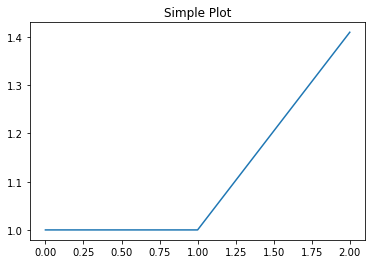

In [5]:
test_arr = [calculate_distance(pt0, pt1, step1_test_print), calculate_distance(pt1, pt2, step1_test_print), calculate_distance(pt0, pt2, step1_test_print)]

simple_plot_graph(test_arr, "Simple Plot", True)

# Step 2: Pairwise Iteration

To calculate the distances between a full array of coordinates, we need pairwise iteration.

Pairwise Iteration Example on a String "ABCDEF" -> AB, BC, CD, DE, EF.

Luckily, [itertools](https://docs.python.org/3/library/itertools.html#itertools.pairwise) exists and provides a receipe on how to do pairwise iteration.

In [6]:
example_path = np.array([[0,0], [0,1], [0,2], [0,3], [0,4]])

In [7]:
# Itertools receipe for pairwise iteration
def pairwise(iterable):
  a, b = it.tee(iterable)
  next(b, None)
  return zip(a, b)

In [8]:
# for my understanding of what the pairwise function does. And from printing the results of pariwise, it pairs up the points so then you can calculate the distance between the points
def printpair(path):
  for p1, p2 in pairwise(path):
    print(p1, p2)

# Pairwise iteration and prints out the values to see what they are
def pairwiseAndPrint(iterable, show=True):
  a, b = it.tee(iterable)
  next(b, None)
  if show:
    for p1, p2 in zip(a, b):
      print(f"{p1},{p2}")
  return zip(a, b)

#pairwiseAndPrint(example_path, False)

We'll combine this pairwise iteration with Python list comprehension to allow us to calculate distances between coordinates for arrays.

In [9]:
def calculate_array_distances(path):
  return np.array([calculate_distance(p1, p2, False) for p1, p2 in pairwise(path)])

In [10]:
# We use list comprehension for this. This is essentially calling the function provided for each pair of arguments we get out of the pairwise iteration 
example_path_distances = calculate_array_distances(example_path)
print(f"{example_path}, \n distances: {example_path_distances}")

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]], 
 distances: [1. 1. 1. 1.]


# Step 3: Simple Example -> Finding Coordinates by Time

We'll consider our distance per second array to be something simple like `[1, 1, 1, 1]`. This means for each of the four seconds, we travel 1 unit in that second.

In [11]:
# distance_per_second
step3_distance_per_second = np.array([1,1,1,1])

We'll also define our path to be 3 steps along the y-axis.

In [12]:
# path
step3_path = np.array([[0,0], [0,1], [0,2], [0,3]])

Use Step 2's work to find distance between path.

In [13]:
# path_distances
step3_path_distances = calculate_array_distances(step3_path)
print(f"{step3_path} \n distances: {step3_path_distances}")

[[0 0]
 [0 1]
 [0 2]
 [0 3]] 
 distances: [1. 1. 1.]


In [14]:
def step3_match_coords(path, path_distances, distance_per_second):
  # path: List of all the coordinates of the path
  # path_distances: List of all the distances between paths
  # distance_per_second: List of all the speeds per second 

  path_distance_index = 0

  coordinate_by_time = [] # coordinates by seconds

  # Use Enumeration, which allows us to use both the iteration number and value while iterating
  # Ex: Iteration 0: i = 0, distance
  # for i, value in enumerate(array) i = 0, 1, 2, value = array[0], array[1]...

  for i, distance in enumerate(distance_per_second):
    print(f"Travelled {distance} m at second {i}")
    
    # If I travelled a distance equal to the next point, I'll add it to the list.
    if path_distances[path_distance_index] == distance:
      # Then, I'll add it to the list of coordinates
      coordinate_by_time.append(path[path_distance_index])
      # Increment the path distance to show I reached that coordinate and ready
      # to analyze the next segment
      path_distance_index += 1

      # Exit if path_distance_index goes out of bounds. Means we reached end of path.
      if(path_distance_index >= len(path_distances)): 
        return np.array(coordinate_by_time)
  
  return np.array(coordinate_by_time) 

In [15]:
step3_coord_by_time = step3_match_coords(path=step3_path, path_distances=step3_path_distances, distance_per_second=step3_distance_per_second)

print(step3_coord_by_time)

Travelled 1 m at second 0
Travelled 1 m at second 1
Travelled 1 m at second 2
[[0 0]
 [0 1]
 [0 2]]


# Step 4: Less Simple Example -> Finding Coordinates by time with more complex speed and distance arrays

Take these speed, distance, and path arrays:  
speed = [1, 2, 1, 1]  
distance = [2, 1, 2, 3] (distance between points)  
path = [[0, 0], [0, 2], [0, 3], [0, 5], [0, 8]]  

The result when calculating the coordinate by time should look something like this:

coordinate_per_second = [[0, 1], [0, 3], [0, 4], [0, 5]]

Index to path:      i = 3      (names in function: path_index)  
Index to distance:  j = 3      (names in function: path_distance_index)  
Note: Not 100% sure if these two indexes are always the same or different

In [16]:
# step4_speed = np.array([1, 2, 1, 1])
step4_speed = np.array([4, 1, 1, 4, 1])
step4_path = np.array([[0, 0], [0, 2], [0, 3], [0, 5], [0, 8]])

step4_path_distances = calculate_array_distances(step4_path)

#print(step4_path_distances)

In [17]:
def step4_match_coords(path, distances, speeds):
  # path: List of all the coordinates of the path
  # path_distances: List of all the distances between paths
  # distance_per_second: List of all the speeds per second
  # delta: margin of error used for float calculations, UPDATE AS NEEDED

  delta = 0.05

  path_index          = 0
  path_distance_index = 0

  temp_distance_travelled = 0

  coords_by_seconds = []

  for i, distance in enumerate(speeds):
    """
    3 cases regarding the speed travelled:
    First: speed + temp_distance_travelled < distance[path_distance_index]
      We keep a result of how far we have travelled, and we calculate the fractional coordinate
    Second: speed = distance[path_distance_index]
      We plot the next point in coordinate per second, increment path_distance_index
    Third: speed + temp_distance_travelled > distance[path_distance_index]
      Decrement the speed distance, increment path_distance_index
      getting the resulting speed to calculate the fractional cooridnate point.
        # what happens if we pass our checkpoint in this case? Doing a check with helper function everytime we increment path_distance_index
    """

    total_distance_travelled = 0

    # First check if we can reach beyond the next path coordinates
    while (distance + temp_distance_travelled > distances[path_distance_index] + delta):
      # Update distance to be remainder of distance we can travel this second
      distance = distance + temp_distance_travelled - distances[path_distance_index]
      # Add the distance travelled to our count
      total_distance_travelled += distances[path_distance_index] - temp_distance_travelled
      # Reset the temp_distance_travelled
      temp_distance_travelled = 0

      # Increment values of path_index and path_distance_index
      path_index += 1
      path_distance_index += 1

      # If we reached the end of the coordinate list, exit
      if(path_distance_index >= len(distances)): 
        print(f"Travelled {total_distance_travelled} m at second {i}")
        print(f"New coordinates: {path[path_index]}")

        # First, add the last coordinate (which we must have reached)
        coords_by_seconds.append(path[path_index])

        return np.array(coords_by_seconds)

    # If I can't reach the next coordinate
    if (distance + temp_distance_travelled < distances[path_distance_index] - delta):
      # Update total distance travelled
      total_distance_travelled += distance
      print(f"Travelled {total_distance_travelled} m at second {i}")

      # Add onto the temperary distance between two coordinates
      temp_distance_travelled += distance
      frac_distance_travelled = temp_distance_travelled / distances[path_distance_index]
      dx = path[path_index + 1][0] - path[path_index][0]
      dy = path[path_index + 1][1] - path[path_index][1]

      # Calculate the new coordinates with the fraction of temporary distance travelled
      new_coords = [frac_distance_travelled * dx + path[path_index][0],
                    frac_distance_travelled * dy + path[path_index][1]]
      coords_by_seconds.append(new_coords)
      print(f"New coordinates: {new_coords}")

    # If I cover just enough distance to reach a new path coordinate
    elif (distances[path_distance_index] - delta <= distance + temp_distance_travelled <= distances[path_distance_index] + delta):
      # Update total distance travelled
      total_distance_travelled += distance
      print(f"Travelled {total_distance_travelled} m at second {i}")

      # Reset our temp_distance_travelled since we reached a new checkpoint
      temp_distance_travelled = 0

      # Increment our values for the path_index and path_distance_index
      path_index += 1
      path_distance_index += 1

      # Add the checkpoint coordinates to the coords_by_second array
      coords_by_seconds.append(path[path_index])
      print(f"New coordinates: {path[path_index]}")

      # If we reached the end of the coordinate list, exit
      if(path_distance_index >= len(distances)):
        return np.array(coords_by_seconds)

  return np.array(coords_by_seconds)


In [18]:
step4_coord_by_times = step4_match_coords(path=step4_path, distances=step4_path_distances, speeds=step4_speed)

print(step4_coord_by_times)

Travelled 4.0 m at second 0
New coordinates: [0.0, 4.0]
Travelled 1 m at second 1
New coordinates: [0 5]
Travelled 1 m at second 2
New coordinates: [0.0, 6.0]
Travelled 2.0 m at second 3
New coordinates: [0 8]
[[0. 4.]
 [0. 5.]
 [0. 6.]
 [0. 8.]]


# Step 5: Less Simple example -> Considering checkpoints and add 0s to arrays

Now let's assume we have another input array containing the coordinates of the checkpoints along the path. First, we need to find the indices the checkpoints occur in the path array (and if they even exist in the array). If they don't exist in the array, we need to find the coordinates that are the closest to the checkpoint, and calculate the fractional distance/coordinates.



Adding 45 minutes worth of 0s in both speed and path arrays:  

If we have speed 4, and next wp at 2, change the speed array from 4 to 2



In [151]:
step5_speed = np.array([4, 1, 1, 4, 1, 4])
step5_path = np.array([[0, 0], [0, 2], [0, 3], [0, 5], [0, 8]])
step5_waypoints = np.array([[0,2], [0,4], [0,5]])

step5_path_distances = calculate_array_distances(step5_path)

#print(step5_path_distances)

In [174]:
def step5_match_coords(path, distances, speeds, waypoints, verbose = False):
  # First we need to find the closest path coordinates for each waypoint/checkpoint
  path_rad = np.array([[radians(p[0]), radians(p[1])] for p in path])
  tree = BallTree(path_rad, metric='haversine')
  gaps, wp = tree.query([[radians(w[0]), radians(w[1])] for w in waypoints])
  # Make sure no waypoint is more than 50 m away from a path coord
  assert(max(gaps) <= 50)
  print(f"Waypoint indices in path array:\n{wp}\n")

  delta                   = 0.05  # margin of error with double arithmetic
  offset                  = 0     # offset for when we add the 0's to speeds array
  path_index              = 0     # current path coordinate
  temp_distance_travelled = 0     # stores the interim distance travelled between two path coordinates
  insert_indices          = []    # stores the indices of the speed array where we need to insert 0's 

  for i, distance in enumerate(speeds):
    """
    3 cases regarding the speed travelled:
    First: speed + temp_distance_travelled < distance[path_distance_index]
      We keep a result of how far we have travelled, and we calculate the fractional coordinate
    Second: speed = distance[path_distance_index]
      We plot the next point in coordinate per second, increment path_distance_index
    Third: speed + temp_distance_travelled > distance[path_distance_index]
      Decrement the speed distance, increment path_distance_index
      getting the resulting speed to calculate the fractional cooridnate point.
        # what happens if we pass our checkpoint in this case? Doing a check with helper function everytime we increment path_distance_index
    """

    total_distance_travelled  = 0 # total distance travelled this second
    flag                      = 0 # flag used to indicate if we reached a waypoint

    # if we can reach the next path coordinate
    while distance + temp_distance_travelled > distances[path_index] - delta:
      # update distance to be remainder of distance we can travel this second
      distance = distance + temp_distance_travelled - distances[path_index]
      # add the distance travelled to our total distance travelled this second
      total_distance_travelled += distances[path_index] - temp_distance_travelled
      # reset the temp_distance_travelled since we just reached a new path coordinate
      temp_distance_travelled = 0

      # increment values of path_index and path_index
      path_index += 1

      # If we reached the end of the coordinate list, exit
      if path_index >= len(distances):
        if verbose:
          print(f"Travelled {total_distance_travelled} m at second {i}\n" \
                f"New coordinates: {path[path_index]}\n"                  \
                "Race complete!\n")
        
        # insert the 0's from waypoints
        for idx in np.flip(insert_indices):
          speeds = np.insert(speeds, idx+1, [0] * 45)
        return np.array(speeds)

      # If we have reached a waypoint/checkpoint, add 0's to speeds
      if wp.size > 0 and path_index == wp[0]:
        if verbose:
          print(f"Travelled {total_distance_travelled} m at second {i}\n" \
                f"New coordinates: {path[path_index]}\n"                  \
                "Reached a waypoint!\n")
        
        # delete the waypoint we just reached from the wp array
        wp = np.delete(wp, 0)
        # update the current speed to be only what we travelled this second
        speeds[i + offset] = total_distance_travelled
        insert_indices.append(i)
        distance = 0  # shouldn't travel anymore in this second
        flag = 1
        break

    if flag:
      continue

    # If I still have distance to travel but can't reach the next coordinate
    if distance + temp_distance_travelled < distances[path_index] - delta:
      # Update total distance travelled
      total_distance_travelled += distance        

      # Add onto the temperary distance between two coordinates
      temp_distance_travelled += distance
      frac_distance_travelled = temp_distance_travelled / distances[path_index]
      dx = path[path_index + 1][0] - path[path_index][0]
      dy = path[path_index + 1][1] - path[path_index][1]

      # Calculate the new coordinates with the fraction of temporary distance travelled
      new_coords = [frac_distance_travelled * dx + path[path_index][0],
                    frac_distance_travelled * dy + path[path_index][1]]
      if verbose:
        print(f"Travelled {total_distance_travelled} m at second {i}\n" \
              f"New coordinates: {new_coords}\n")

    # If I cover just enough distance to reach a new path coordinate
    # elif (distances[path_distance_index] - delta <= distance + temp_distance_travelled <= distances[path_distance_index] + delta):
    #   # Update total distance travelled
    #   total_distance_travelled += distance
    #   print(f"3. Travelled {total_distance_travelled} m at second {i}")
    #   # print(f"currently on path idx {path_index}")

    #   # Reset our temp_distance_travelled since we reached a new checkpoint
    #   temp_distance_travelled = 0

    #   # Increment our values for the path_index and path_distance_index
    #   path_index += 1
    #   path_distance_index += 1

    #   # Add the path coordinate to the coords_by_second array
      
    #   coords_by_seconds.append(path[path_index])
    #   print(f"New coordinates: {path[path_index]}")

    #   # If we reached the end of the coordinate list, exit
    #   if(path_distance_index >= len(distances)):
    #     return np.array(speeds)

    #   # If we reached a waypoint
    #   if wp.size > 0 and path_index == wp[0]:
    #     wp = np.delete(wp, 0)
    #     speeds[i + offset] = total_distance_travelled
    #     speeds = np.insert(speeds, i+1+offset, [1010])
    #     offset += 1

  if verbose:
    print("Didn't have enough speed to complete race.")
  # insert the 0's from waypoints
  for idx in np.flip(insert_indices):
    speeds = np.insert(speeds, idx+1, [0] * 45)
  return np.array(speeds)


In [175]:
step5_coord_by_times = step5_match_coords(path=step5_path, distances=step5_path_distances, speeds=step5_speed, waypoints=step5_waypoints, verbose=True)

print(step5_coord_by_times)

Waypoint indices in path array:
[[1]
 [2]
 [3]]

Travelled 2.0 m at second 0
New coordinates: [0 2]
Reached a waypoint!

Travelled 1.0 m at second 1
New coordinates: [0 3]
Reached a waypoint!

Travelled 1 m at second 2
New coordinates: [0.0, 4.0]

Travelled 1.0 m at second 3
New coordinates: [0 5]
Reached a waypoint!

Travelled 1 m at second 4
New coordinates: [0.0, 6.0]

Travelled 2.0 m at second 5
New coordinates: [0 8]
Race complete!

[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4]


In [145]:
### TESTING CODE

def test():
	offset = 0

	insert = [0,3,4]

	waypoints = np.array([0,2,4])
	arr = np.array([1,2,3,4,5])
	# print(arr)
	# for i, x in enumerate(arr):
	# 	if waypoints.size > 0 and i == waypoints[0]:
	# 		waypoints = np.delete(waypoints, 0)
	# 		arr = np.insert(arr, i + 1 + offset, [0] * 2)
	# 		offset += 2
	print(arr)

	# insert = np.flip(insert)

	for x in np.flip(insert):
		arr = np.insert(arr, x+1, [0]*10)

	print(arr)


In [146]:
test()

[1 2 3 4 5]
[1 0 0 0 0 0 0 0 0 0 0 2 3 4 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]


Use simple_plot_graph from helpers.py to graph the speeds to estimate if it is reasonable